In [158]:
from __future__ import annotations

import math
from scipy import ndimage as ndi
import datetime as dt
from dateutil.tz import tzutc
from collections import defaultdict
import numpy as np
from typing import Optional, Tuple, Any
import matplotlib.pyplot as plt
import getpass

from scipy.ndimage import binary_dilation, generate_binary_structure

import pandas as pd
from sentinelhub import (
    SHConfig,
    BBox, 
    CRS,
    bbox_to_dimensions,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubStatistical,
    SentinelHubRequest,
    MimeType,
)

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [159]:
AOI_COORDS_WGS84 = [13.552322, 52.399591, 13.799515, 52.485394]
RESOLUTION = 10
SHORE_WIDTH = 50
aoi_bbox = BBox(bbox=AOI_COORDS_WGS84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=RESOLUTION)
aoi_size

(1698, 924)

In [109]:
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [104]:
# config = SHConfig("cdse")
# config

SHConfig(
  instance_id='',
  sh_client_id='',
  sh_client_secret='',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
  max_retries=None,
)

In [226]:
evalscript_scl = """
function setup() {
  return {
    input: ["SCL", "dataMask"],
    output: { id: "scl", bands: 1, sampleType: "UINT8" }
  };
}

const classes = {
  0: [0, 0, 0], // No Data (Missing data) - black  
  1: [255, 0, 0], // Saturated or defective pixel - red 
  2: [47, 47, 47], // Topographic casted shadows ("Dark features/Shadows" for data before 2022-01-25) - very dark grey
  3: [100, 50, 0], // Cloud shadows - dark brown
  4: [0, 160, 0], // Vegetation - green
  5: [255, 230, 90], // Not-vegetated - dark yellow
  6: [0, 0, 255], // Water (dark and bright) - blue
  7: [128, 128, 128], // Unclassified - dark grey
  8: [192, 192, 192], // Cloud medium probability - grey
  9: [255, 255, 255], // Cloud high probability - white
  10: [100, 200, 255], // Thin cirrus - very bright blue
  11: [255, 150, 255], // Snow or ice - very bright pink
}

function evaluatePixel(samples) {
  // return black if key not available
  let imgVals = classes[samples.SCL] || [0, 0, 0];
  return {
    default: imgVals,
    scl: [samples.SCL]
  };
}
"""

evalscript_ndvi = """
//VERSION=3
function setup() {
   return {
      input: ["B04", "B08", "dataMask"],
      output: {id: "ndvi", bands: 1, sampleType: "FLOAT32"} 
   };
}

const ramp = [
   [-0.5, 0x0c0c0c],
   [-0.2, 0xbfbfbf],
   [-0.1, 0xdbdbdb],
   [0, 0xeaeaea],
   [0.025, 0xfff9cc],
   [0.05, 0xede8b5],
   [0.075, 0xddd89b],
   [0.1, 0xccc682],
   [0.125, 0xbcb76b],
   [0.15, 0xafc160],
   [0.175, 0xa3cc59],
   [0.2, 0x91bf51],
   [0.25, 0x7fb247],
   [0.3, 0x70a33f],
   [0.35, 0x609635],
   [0.4, 0x4f892d],
   [0.45, 0x3f7c23],
   [0.5, 0x306d1c],
   [0.55, 0x216011],
   [0.6, 0x0f540a],
   [1, 0x004400],
];

function evaluatePixel(samples) {
  let ndvi = index(samples.B08, samples.B04);
  return {
    ndvi: [ndvi]
  };
}"""

time_intervals = [
    ("2017-07-03T00:00:00Z", "2017-07-03T23:59:59Z"),
    ("2016-07-21T00:00:00Z", "2016-07-21T23:59:59Z"),
    ("2018-07-01T00:00:00Z", "2018-07-01T23:59:59Z"),
    ("2019-07-01T00:00:00Z", "2019-07-01T23:59:59Z"),
    ("2020-07-12T00:00:00Z", "2020-07-12T23:59:59Z"),
    ("2021-07-15T00:00:00Z", "2021-07-15T23:59:59Z"),
    ("2022-07-02T00:00:00Z", "2022-07-02T23:59:59Z"),
    ("2023-07-07T00:00:00Z", "2023-07-07T23:59:59Z"),
    ("2024-07-06T00:00:00Z", "2024-07-06T23:59:59Z"),
    ("2025-07-01T00:00:00Z", "2025-07-01T23:59:59Z")
]

def shoreline_band_inland_dilate(water_mask: np.ndarray, pixel_size_m: float, shore_width_m: float) -> np.ndarray:
    k = max(1, int(math.ceil(shore_width_m / pixel_size_m)))
    expanded = binary_dilation(water_mask, iterations=k)  # expand water into land
    shore = expanded & (~water_mask)  # keep only inland part
    return shore

def shoreline_band_inland(water_mask: np.ndarray, pixel_size_m: float, shore_width_m: float) -> np.ndarray:
    """
    Returns a boolean mask of land pixels within `shore_width_m` of water,
    measured inland from the water edge.
    """
    land = ~water_mask  # True = land
    dist_to_water_m = ndi.distance_transform_edt(land, sampling=pixel_size_m)
    shore = land & (dist_to_water_m > 0) & (dist_to_water_m <= shore_width_m)
    return shore

In [ ]:
ndvi_data_years = []
ndvi_avg_years = []
ndvi_std_years = []
ndvi_ci_years = []

for year in range(2017, 2026):
    print(year)
    scl_request = SentinelHubRequest(
        evalscript=evalscript_scl,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(f"{year}-05-01T00:00:00Z", f"{year}-08-31T23:59:59Z"),
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response(identifier="scl", response_format=MimeType.TIFF)],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config
    )
    scl_data = scl_request.get_data()[0]
    radius_pixels = int(SHORE_WIDTH / RESOLUTION)

    water_mask = (scl_data == 6)
    struct = generate_binary_structure(2, 1)
    for _ in range(radius_pixels-1):
        struct = binary_dilation(struct)

    expanded_water = binary_dilation(water_mask, structure=struct)
    shore_mask = shoreline_band_inland(water_mask, RESOLUTION, shore_width_m=SHORE_WIDTH)
    
    ndvi_request = SentinelHubRequest(
        evalscript=evalscript_ndvi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(f"{year}-05-01T00:00:00Z", f"{year}-08-31T23:59:59Z"),
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response('ndvi', response_format=MimeType.TIFF)],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config
    )
    
    ndvi_data = ndvi_request.get_data()[0]
    # ndvi_data = (ndvi_data - ndvi_data.min()) / (ndvi_data.max() - ndvi_data.min())
    ndvi_data = np.where(shore_mask, ndvi_data, np.nan)
    
    flat_ndvi = ndvi_data.flatten()
    flat_ndvi = flat_ndvi[~np.isnan(flat_ndvi)]
    
    ndvi_avg = flat_ndvi.mean()
    ndvi_std = flat_ndvi.std()
    ndvi_size = flat_ndvi.size
    
    ndvi_ci = 1.96 * (ndvi_std / np.sqrt(ndvi_size))
    
    ndvi_data_years.append(ndvi_data)
    ndvi_avg_years.append(ndvi_avg)
    ndvi_std_years.append(ndvi_std)
    ndvi_ci_years.append(ndvi_ci)
    
    plot_image(ndvi_data, factor=3.5 / 255)
    plt.savefig(f'ndvi_{year}.png')
    # plt.show()

2017
2018


(array([   36.,   264.,  1469.,  3238.,  3286.,  3559.,  4575.,  6598.,
        12497.,  6458.]),
 array([-0.31829575, -0.18646617, -0.0546366 ,  0.07719299,  0.20902255,
         0.34085211,  0.47268173,  0.60451126,  0.73634088,  0.8681705 ,
         1.        ]),
 <BarContainer object of 10 artists>)

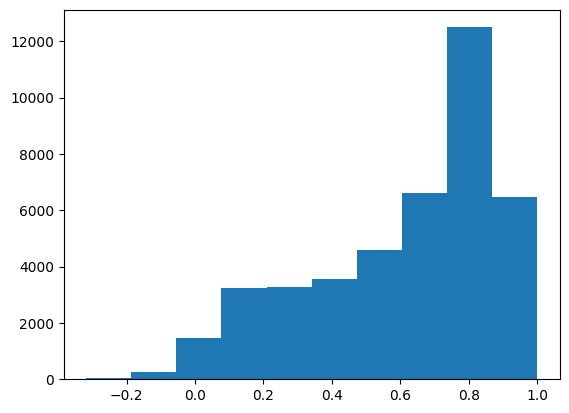

In [228]:
plt.hist(ndvi_data_years[0][np.isfinite(ndvi_data_years[0])])

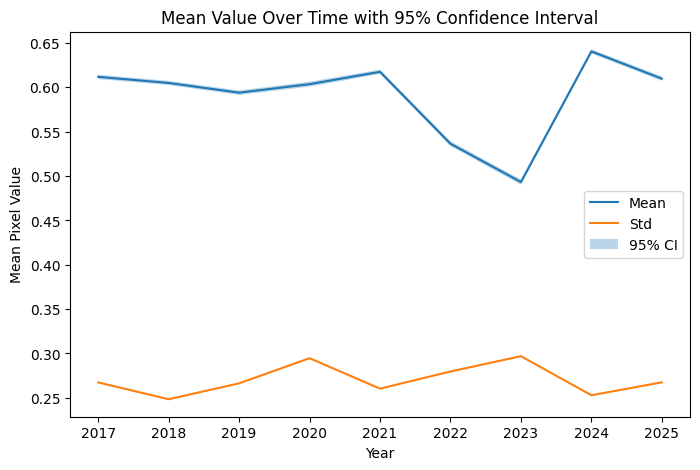

In [229]:
def plot_mean_ci(years, means, cis, stds):
    plt.figure(figsize=(8,5))
    
    plt.plot(years, means, label="Mean")
    plt.plot(years, stds, label="Std")
    plt.fill_between(years, means - cis, means + cis, alpha=0.3, label="95% CI")
    
    plt.xlabel("Year")
    plt.ylabel("Mean Pixel Value")
    plt.title("Mean Value Over Time with 95% Confidence Interval")
    plt.legend()
    # t.ylim((0, 1))
    plt.show()
    
plot_mean_ci(range(2017, 2026), np.array(ndvi_avg_years), np.array(ndvi_ci_years), stds=np.array(ndvi_std_years))

<Axes: >

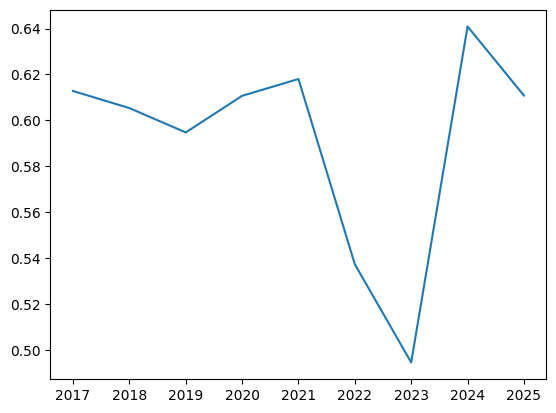

In [206]:
import seaborn as sns
sns.lineplot(x=range(2017, 2026), y=ndvi_avg_years)

In [201]:
ndvi_data_years[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(924, 1698))

In [185]:
scl_request = SentinelHubRequest(
    evalscript=evalscript_scl,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=(f"2018-07-01T00:00:00Z", f"2018-07-31T23:59:59Z"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response(identifier="scl", response_format=MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config
)
scl_data = scl_request.get_data()[0]
scl_data.sum()

np.uint64(6742631)

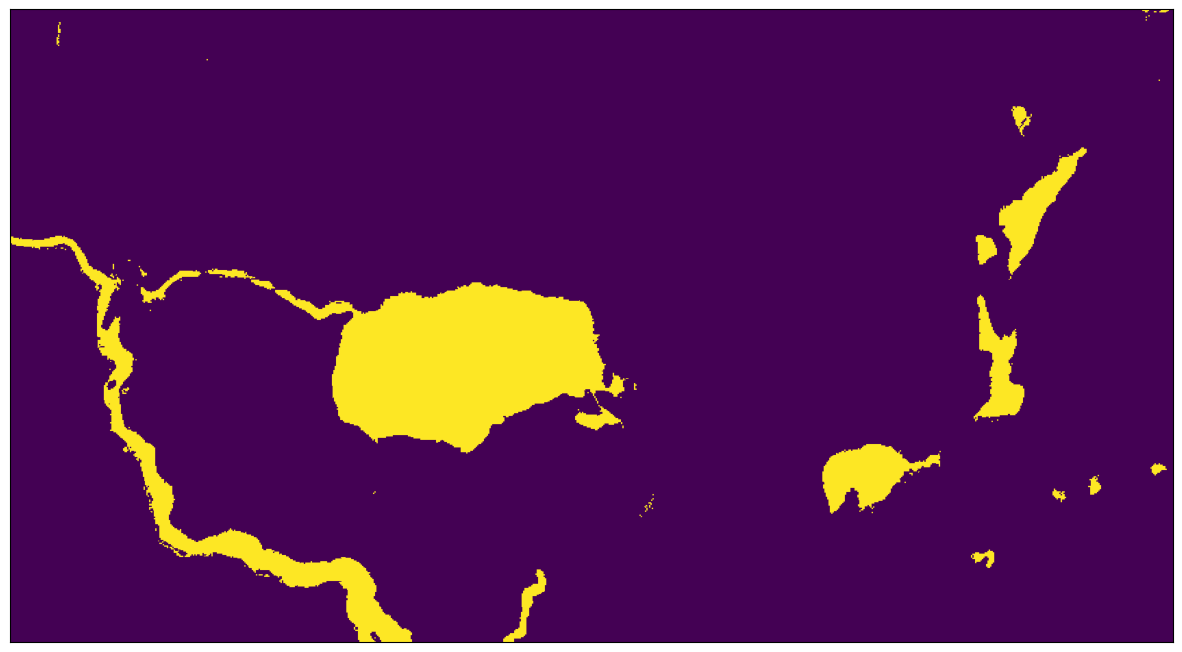

In [187]:
plot_image(scl_data == 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5].


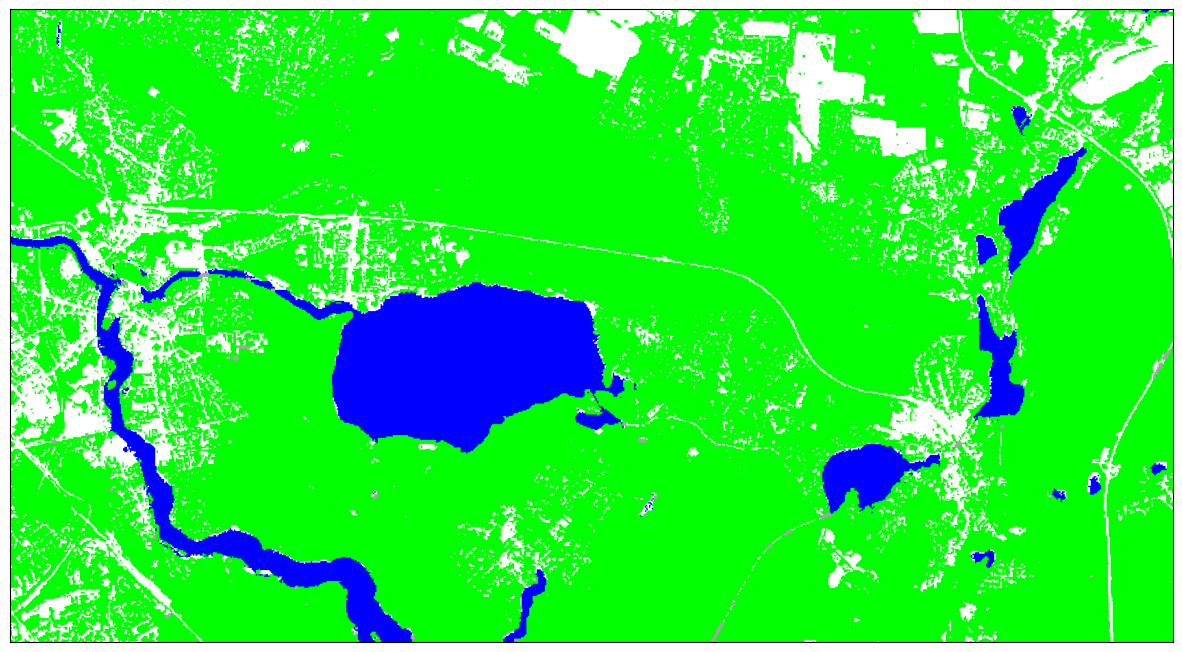

In [178]:
plot_image(scl_data, factor=3.5 / 255)

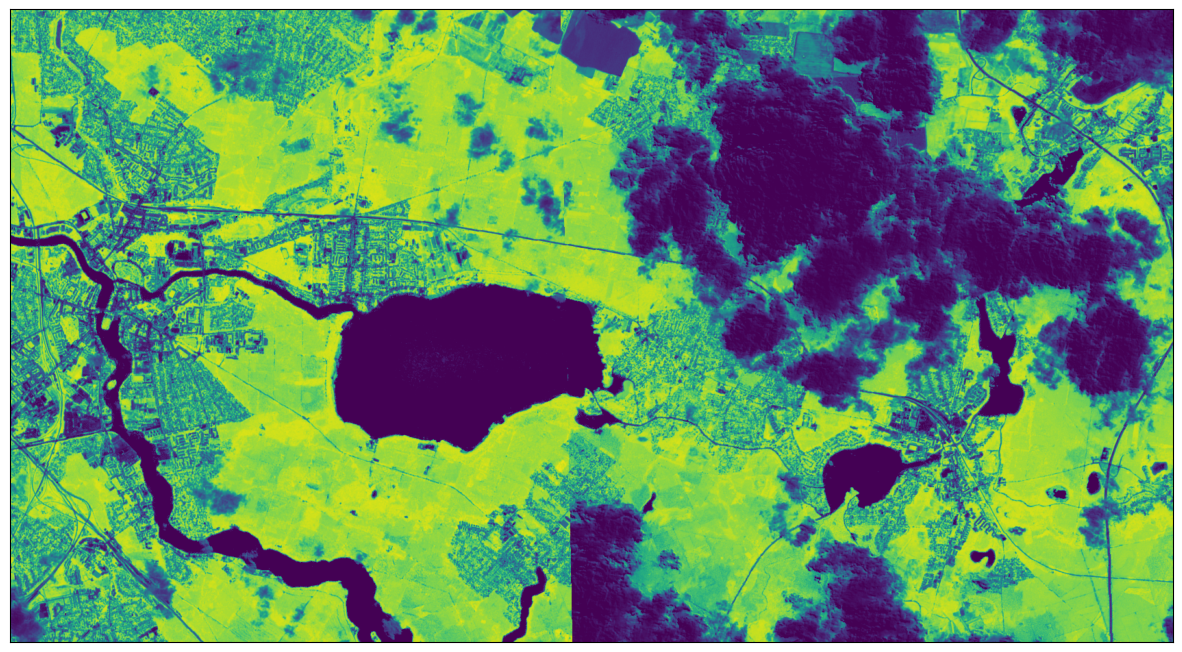

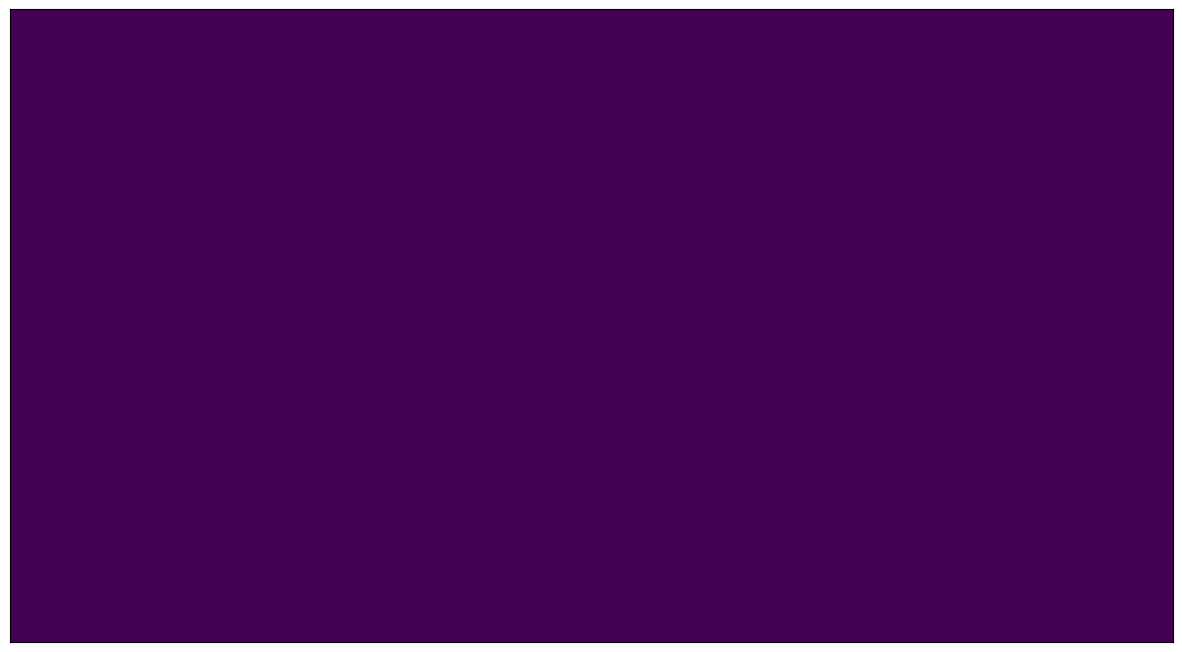

In [157]:
plot_image(scl_data, factor=3.5 / 255)

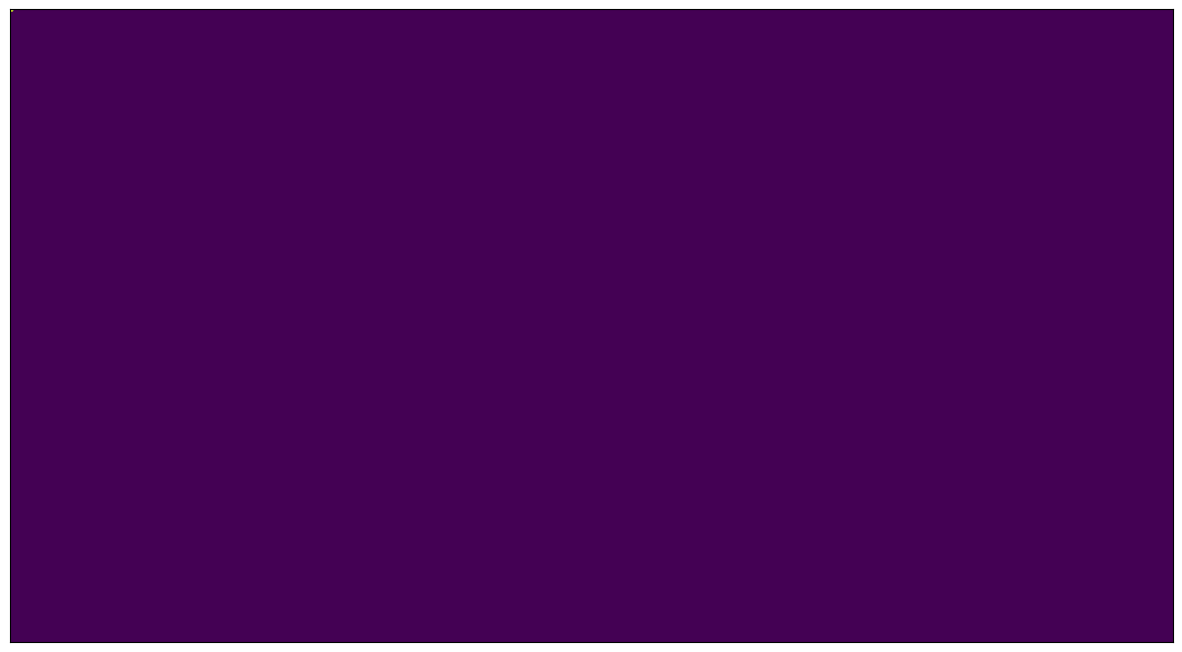

In [151]:
plot_image(np.where(shore_mask, ndvi_data[0], 0))

[np.float32(0.611784),
 np.float32(0.6049293),
 np.float32(0.5939599),
 np.float32(0.60355705),
 np.float32(0.6174915),
 np.float32(0.5364203),
 np.float32(0.4932203),
 np.float32(0.640487),
 np.float32(0.60976815)]

In [232]:
pd.DataFrame({
    'years': list(range(2017, 2026)),
    'mean': ndvi_avg_years,
    'std': ndvi_std_years,
    'ci': ndvi_ci_years
}).to_csv('ndvi.csv', index=False)